In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

In [3]:
# Load datasets
train = pd.read_csv("data/Train.csv")
test = pd.read_csv("data/Test.csv")
toilets = pd.read_csv("data/toilets.csv")
waste_management = pd.read_csv("data/waste_management.csv")
water_sources = pd.read_csv("data/water_sources.csv")

In [16]:
# view some rows of toilets dataset
toilets.head()

,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,...,toilet_tp,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon,Month_Year_lat_lon
0,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536
1,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,...,0.003201,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536
2,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,...,0.004682,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536
3,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,...,0.007518,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536
4,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,...,0.005989,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536


In [14]:
# Display the first few records in the train dataset
train.head()
train.describe()

,Total,Month,Year,Transformed_Latitude,Transformed_Longitude
count,23847.000000,23848.000000,23848.000000,23848.00000,23848.000000
mean,8.355600,6.568643,2020.610282,-8.61252,68.242682
std,28.076713,3.445577,1.133108,0.04251,0.029114
min,0.000000,1.000000,2019.000000,-8.71376,68.169720
25%,0.000000,4.000000,2020.000000,-8.62656,68.224740
50%,0.000000,7.000000,2021.000000,-8.61740,68.237620
75%,3.000000,10.000000,2022.000000,-8.59431,68.257640
max,489.000000,12.000000,2022.000000,-8.49681,68.328390


In [15]:
# Display the first few records in the test dataset
test.head()

,Location,Disease,Month,Category_Health_Facility_UUID,Year,Transformed_Latitude,Transformed_Longitude,ID
0,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,1,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_1_2023...
1,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,2,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_2_2023...
2,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,3,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_3_2023...
3,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,4,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_4_2023...
4,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,5,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_5_2023...


In [4]:
# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [6]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

KeyError: "['Year', 'Month'] not found in axis"

In [7]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")


In [8]:
# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

C:\Users\michael\AppData\Local\Temp\ipykernel_17808\2382225560.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hospital_data['Total'].fillna(0, inplace=True)


In [9]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [12]:
# Visualize locations for a specific year and month
# Note the months/year should in the given timeframe [2019, 2023]
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(12, 8))
    subsets = [
        (hospital_data.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_sources.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_management.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.6, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

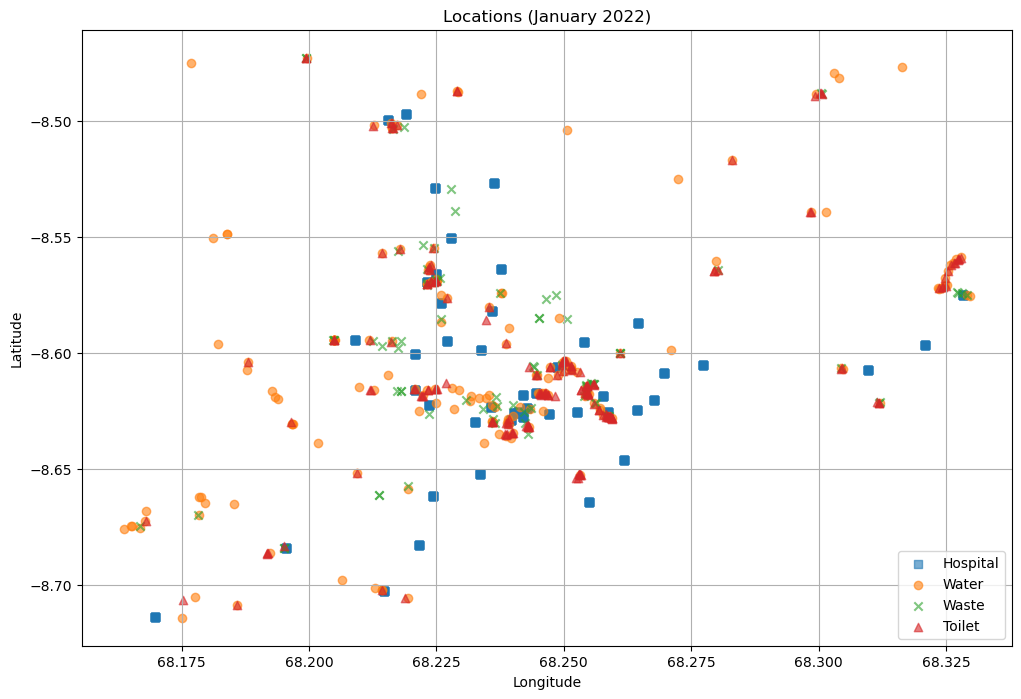

In [19]:
plot_locations()

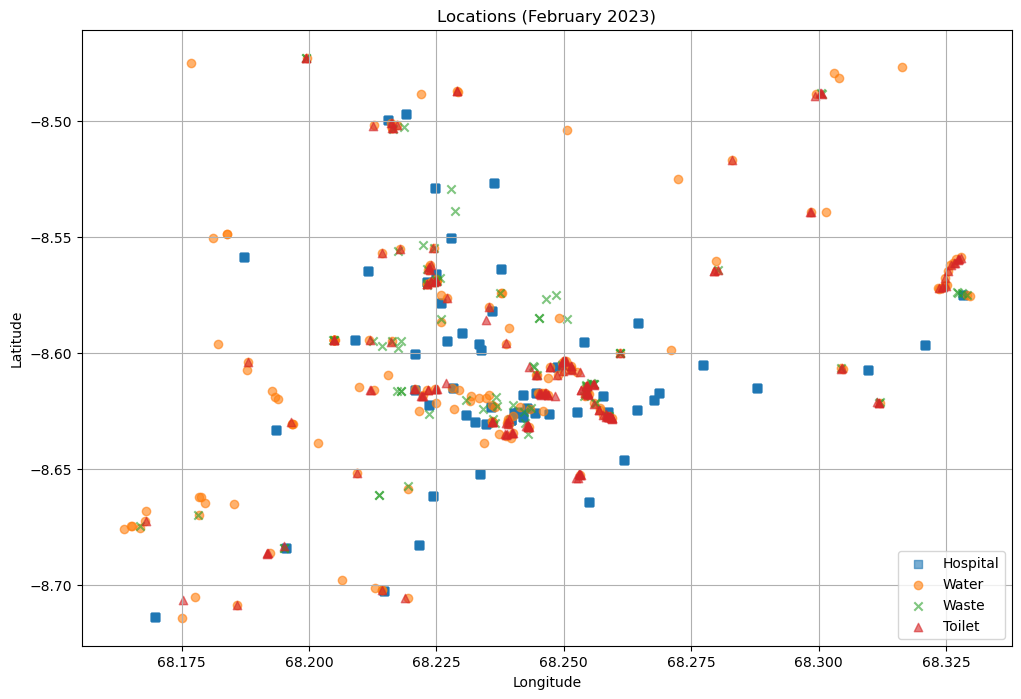

In [21]:
plot_locations(year=2023, month=2, month_name='February')

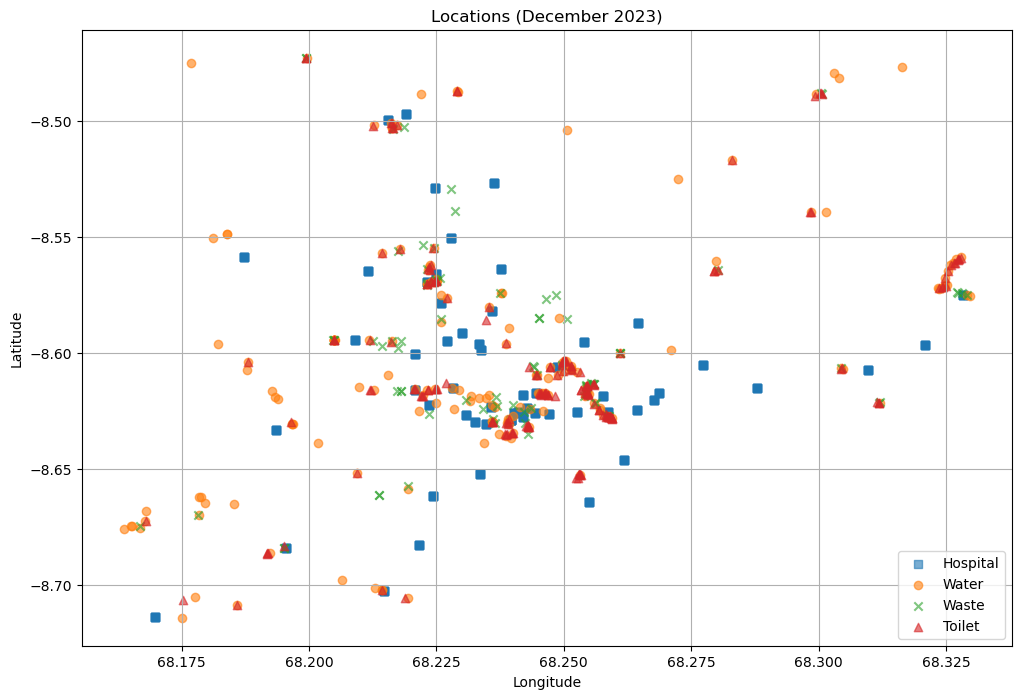

In [23]:
plot_locations(year=2023, month=12, month_name='December')

In [25]:
plot_locations(year=2000, month=1, month_name='January')

Invalid year. Please choose a year between 2019 and 2023.


In [27]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest


In [29]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [31]:
toilets.head()

,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,...,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon,Month_Year_lat_lon,toilet_Month_Year_lat_lon
0,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,...,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536,1_2019_-8.61768_68.24536
1,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,...,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536,2_2019_-8.61768_68.24536
2,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,...,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536,3_2019_-8.61768_68.24536
3,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,...,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536,4_2019_-8.61768_68.24536
4,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,...,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536,5_2019_-8.61768_68.24536


In [33]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [35]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

In [36]:
merged_data.shape

(29332, 135)

In [37]:
merged_data.head(2)

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,...,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,2_2021_-8.62979_68.23582,...,0.000384,0.177307,0.233856,0.305756,0.391357,-8.62966,68.23589,6_2020,-8.62966_68.23589,6_2020_-8.62966_68.23589
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,2_2021_-8.62979_68.23582,...,0.000384,0.177307,0.233856,0.305756,0.391357,-8.62966,68.23589,6_2020,-8.62966_68.23589,6_2020_-8.62966_68.23589


## Start modeling

In [39]:
# Split merged data into train and test sets
train_df = merged_data[merged_data['Year'] < 2023]
test_df = merged_data[merged_data['Year'] == 2023]

In [40]:
# Specify the target column
target_column = 'Total'

# Feature and target split
X = train_df.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns
y = train_df[target_column]

In [41]:
# Handle categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [42]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Initialize and train the regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [52]:
# Make predictions
y_pred = model.predict(X_test)

In [54]:
y_pred

array([ 3.14613095,  0.        ,  0.078     , ...,  0.06      ,
        2.47197619, 31.52457143])

In [56]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 11.015741584014672


#### Make predictions on test

In [59]:
# Prepare test data
X_test_final = test_df.drop(columns=['Total', 'ID', 'Location'], errors='ignore')

In [61]:
# Handle categorical features in test data
for col in categorical_cols:
    if col in X_test_final.columns:
        le = LabelEncoder()
        X_test_final[col] = le.fit_transform(X_test_final[col])

In [63]:
# Align test dataset with training features
for col in X.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = 0  # Add missing feature with default value (e.g., zero)


In [65]:
# Ensure columns are in the same order as training
X_test_final = X_test_final[X.columns]

In [67]:
# Make predictions on test data
predictions = model.predict(X_test_final)

In [70]:
# Create the final DataFrame with ID and predictions
sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions

In [72]:
# View the first few records in sub
sub.head()

,ID,Predicted_Total
24376,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_1_2023...,30.125968
24377,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_2_2023...,27.070024
24378,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_3_2023...,48.409452
24379,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_4_2023...,18.613667
24380,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_5_2023...,18.957833


In [74]:
# Save the final DataFrame to a CSV
sub.to_csv('Benchmark.csv', index=False)